In [1]:
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time
from matplotlib import pyplot as plt
import os
from pprint import pprint

In [2]:
train_dataset = CityScapesDataset(csv_file='./Data/train.csv')
val_dataset = CityScapesDataset(csv_file='./Data/val.csv')
test_dataset = CityScapesDataset(csv_file='./Data/test.csv')

_batch_size = 8
_num_workers = 4
iou_classes = [11, 20, 24, 26, 33]

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=_batch_size,
                          num_workers=_num_workers,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=_batch_size,
                          num_workers=_num_workers,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          num_workers=_num_workers,
                          shuffle=True)

In [3]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform(m.bias.data)
        m.bias.data.zero_()
        
epochs     = 100
criterion = nn.CrossEntropyLoss()# Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
fcn_model = FCN(n_class=n_class)
# for name, params in fcn_model.named_parameters():
#     print(name, params.shape, params.requires_grad)
    
fcn_model.apply(init_weights)
#fcn_model = torch.load('best_model')

optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

In [4]:
modelName = 'fcn'
MYDIR = "./Results" + "/" + modelName
CHECK_FOLDER = os.path.isdir(MYDIR)
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)
else:
    print(MYDIR, "folder already exists.")

def plotTwoGraphs(base, train_metrics, val_metrics):
    plt.figure()
    plt.plot(base, train_metrics)
    plt.plot(base, val_metrics)
    plt.gca().legend(('train','validation'))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.savefig(MYDIR + '/loss.png')

def plotGraph(base, metrics, name):
    plt.figure()
    plt.plot(base, metrics)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.title(name + ' vs Epochs')
    plt.savefig(MYDIR + '/' + name + '.png')
    

./Results/fcn folder already exists.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

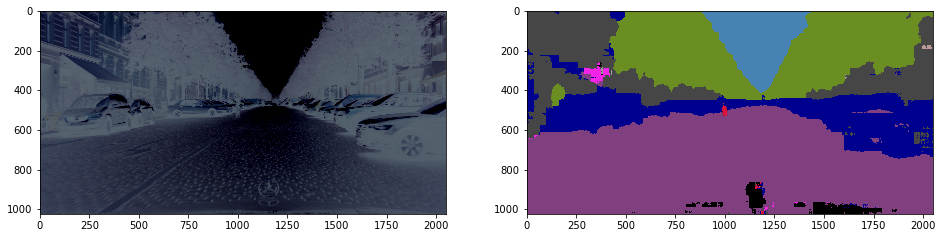

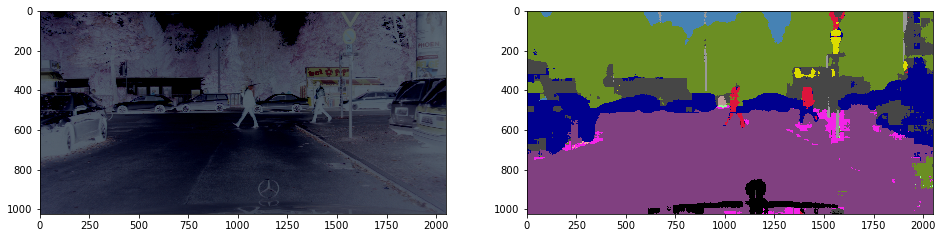

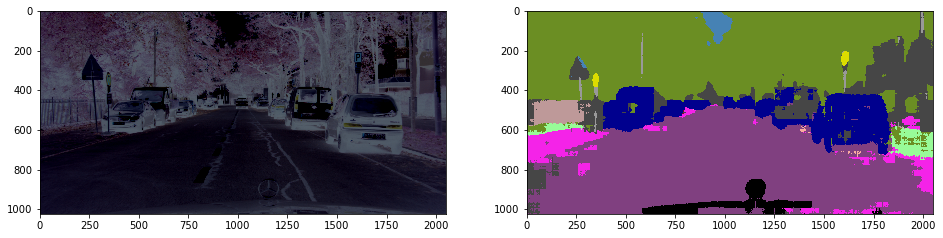

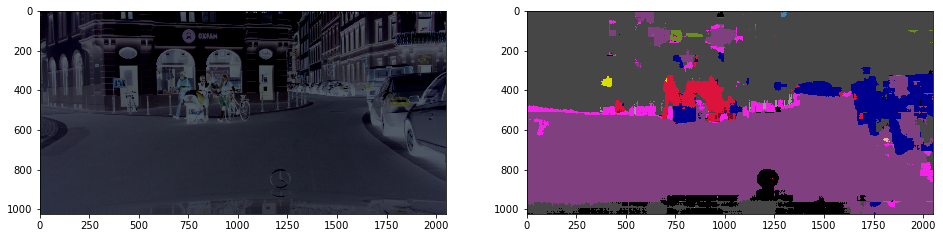

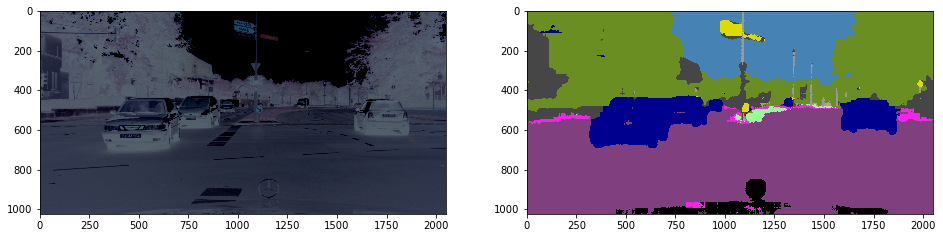

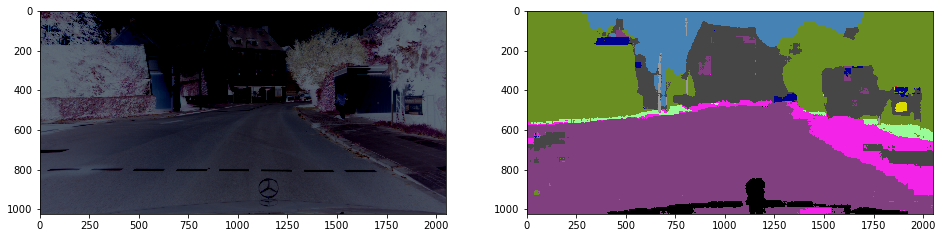

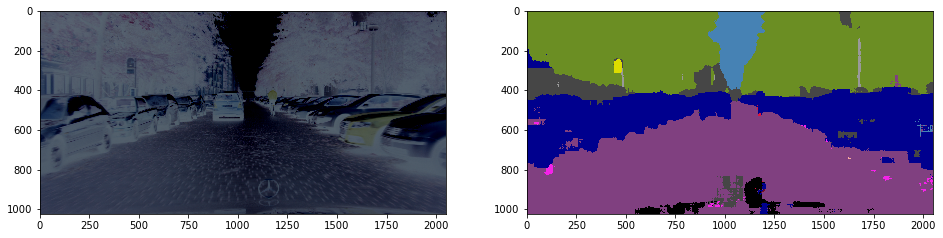

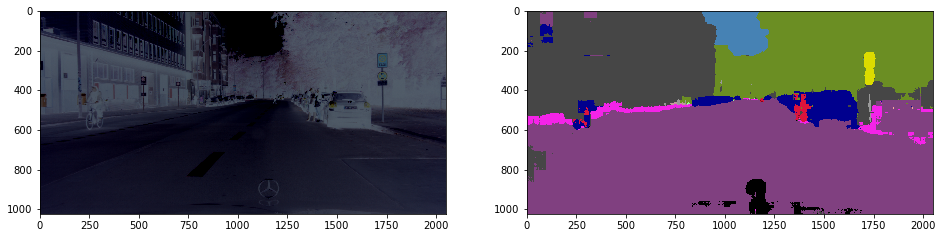

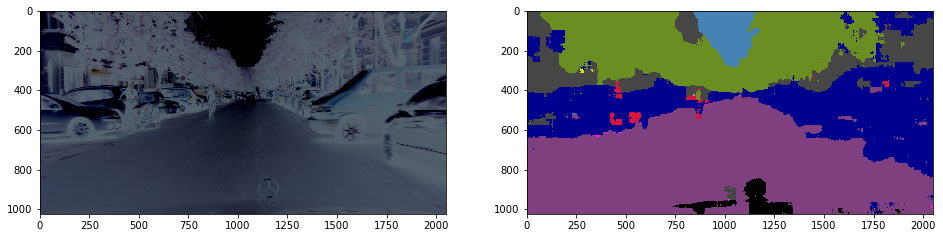

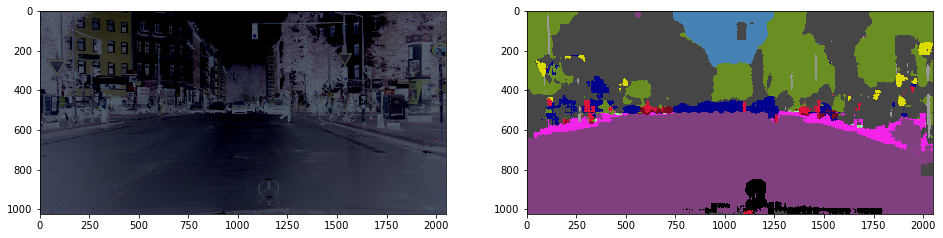

In [6]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    fcn_model = fcn_model.cuda()
    
all_train_losses = []
all_val_losses = []
all_val_accuracies = []
all_val_iou = []
all_val_iou_class = {}


        
def train():
    startingValLoss = 10000000.0
    for epoch in range(epochs):
        fcn_model.train()
        curEpochLoss = []
        ts = time.time()
        for iter, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.cuda()   # Move your inputs onto the gpu
                labels = Y.cuda() # Move your labels onto the gpu
            else:
                inputs, labels = X, Y# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            curEpochLoss.append(loss.item())
            loss.backward()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item(), time.time() - ts))
        curEpochLoss = sum(curEpochLoss)/len(curEpochLoss)
        print('training loss : ', curEpochLoss)
        all_train_losses.append(curEpochLoss)
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        
        
        val_loss, val_accuracy, val_iou_net, val_iou_net_class_wise = val(epoch)
        all_val_losses.append(val_loss)
        all_val_accuracies.append(val_accuracy)
        all_val_iou.append(val_iou_net)
        for c in val_iou_net_class_wise:
            if(c not in all_val_iou_class):
                all_val_iou_class[c] = []
            all_val_iou_class[c].append(val_iou_net_class_wise[c])
        
        plotTwoGraphs([i for i in range(epoch+1)], all_train_losses, all_val_losses)
        plotGraph([i for i in range(epoch+1)], all_val_accuracies, 'validation_accuracy')
        plotGraph([i for i in range(epoch+1)], all_val_iou, 'average_iou')
        for c in all_val_iou_class:
            plotGraph([i for i in range(epoch+1)], all_val_iou_class[c], 'iou'+str(c))
        
        if(val_loss < startingValLoss):
            startingValLoss = val_loss
            results = {}
            results['accuracy'] = val_accuracy
            results['iou_net'] = val_iou_net
            results['iou_net_class_wise'] = val_iou_net_class_wise
            results['total_loss'] = val_loss
            results['epoch'] = epoch
            with open(MYDIR + '/results_val.txt', 'wt') as out:
                pprint(results, stream=out)
            torch.save(fcn_model, MYDIR + '/best_model')
            #test(epoch)
    


def val(epoch):
    fcn_model.eval()
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    total_loss = []
    acc_num = 0
    acc_den = 0
    #iou_num = len(iou_classes)*[0] 
    #iou_den = len(iou_classes)*[0] 
    iou_num = {}
    iou_den = {}
    
    for iter, (X_val, tar_val, Y_val) in enumerate(val_loader):
        if use_gpu:
            inputs_val = X_val.cuda()   # Move your inputs onto the gpu
            labels_val = Y_val.cuda() # Move your labels onto the gpu
        else:
            inputs_val, labels_val = X_val, Y_val# Unpack variables into inputs and labels

        outputs_val = fcn_model(inputs_val)
        
        _, preds = torch.max(outputs_val, 1)
        
        loss_val = criterion(outputs_val, labels_val).item()
        
        preds_cpu = preds.cpu()
        Y_cpu = Y_val.cpu()
        
        total_loss.append(loss_val)
        
        nn, dd = pixel_acc(preds_cpu, Y_cpu)
        acc_num += nn
        acc_den += dd
        
        for iou_cc_idx in range(len(iou_classes)):
            i_nn, i_dd = iou(preds_cpu, Y_cpu, iou_classes[iou_cc_idx])
            if iou_cc_idx not in iou_num:
                iou_num[iou_cc_idx] = 0
                iou_den[iou_cc_idx] = 0
            iou_num[iou_cc_idx] += i_nn
            iou_den[iou_cc_idx] += i_dd
            
        del inputs_val
        del labels_val
        del loss_val
    total_loss = sum(total_loss)/len(total_loss)
    print("Validation loss after epoch {}, , loss: {}".format(epoch, total_loss))
    print("Accuracy on val after epoch {}, accuracy: {}".format(epoch, 100*acc_num/acc_den))
    for iou_cc_idx in range(len(iou_classes)):
        print("IOU for class {} on val after epoch{}, iou: {}".format(iou_classes[iou_cc_idx], epoch, 100*iou_num[iou_cc_idx]/iou_den[iou_cc_idx]))

    iou_net_class_wise = dict((c, iou_num[c]/iou_den[c]) for c in iou_num)
    accuracy = acc_num / acc_den
    iou_net_num = 0
    iou_net_den = 0
    for c in iou_num:
        iou_net_num += iou_num[c]
        iou_net_den += iou_den[c]
    iou_net = iou_net_num/iou_net_den

    return total_loss, accuracy, iou_net, iou_net_class_wise

def colorMap(a, i):
    return idsColor[a][i]

def test(numFigures):
    #fcn_model.load_state_dict(torch.load(MYDIR + '/best_model'))
    model = torch.load(MYDIR + '/best_model')
    model.cuda()
    model.eval()
    dataiter = iter(test_loader)
    i = 0
    while(i < numFigures):
        i += 1
        X_test, img_full, Y_test = dataiter.next()
        if use_gpu:
            inputs_test = X_test.cuda()   # Move your inputs onto the gpu
            labels_test = Y_test.cuda() # Move your labels onto the gpu
            #img_full_test = img_full.cuda()
        else:
            inputs_test, labels_test = X_test, Y_test# Unpack variables into inputs and labels
            #img_full_test = img_full

        outputs = model(inputs_test)
        _, preds = torch.max(outputs, 1)
        inputs_test = inputs_test.permute(0, 2, 3, 1)
        #img_full_test = img_full_test.permute(0, 2, 3, 1)

        f = plt.figure(figsize=(16,8))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)

        #plt.subplot(1, 2, 1)
        ax.imshow(torchvision.utils.make_grid(-1*inputs_test.cpu()))


        preds = preds.cpu().numpy()

        preds0 = np.vectorize(colorMap)(preds, 0)
        preds1 = np.vectorize(colorMap)(preds, 1)
        preds2 = np.vectorize(colorMap)(preds, 2)

        preds = torch.from_numpy(np.transpose(np.concatenate((preds0, preds1, preds2), 0), (1,2,0)))

        #plt.subplot(1, 2, 2)
        ax2.imshow(torchvision.utils.make_grid(preds.cpu()))
    
    
    
    
    
    
    
    
    
#     X_test = X_test.permute(0, 2, 3, 1)
#     plt.imshow(torchvision.utils.make_grid(-1*X_test))
#     outputs = model(X_test)
#     _, preds = torch.max(outputs, 1)
#     print(preds.Size())
    
        
        
        
    
    
              
    
if __name__ == "__main__":
    test(10)
    #train()